In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [36]:
image_datasets = {'train': datasets.FashionMNIST(root='', train=True, download=False,
                                               transform=transforms.Compose([transforms.Resize((224,224)),
                                                                            transforms.ToTensor(),
                                                                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])),
                 'val': datasets.FashionMNIST(root='', train=False, download = False,
                                               transform=transforms.Compose([transforms.Resize((224,224)),
                                                                            transforms.ToTensor(),
                                                                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [65]:
def train(model, criterion, optimizer, scheduler, num_epochs=20):
    zero = time.time()
    
    model_wts = copy.deepcopy(model.state_dict())
    conv_wts = conv.state_dicts()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch ', epoch)
        print('\n')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                images, labels = data

                if torch.cuda.is_available():
                    images, labels = Variable(images.cuda()), Variable(labels.cuda())

                else:
                    images, labels = Variable(images), Variable(labels)

                optimizer.zero_grad()

                outputs = conv(images)
                
                outputs = model(outputs)

                _, predictions = torch.max(outputs.data, 1)

                loss = Loss(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss +=loss.data[0] * images.size(0)
                running_corrects += (predictions == labels.data).sum()

            epoch_loss = running_loss/ (i*images.size(0))
            epoch_acc = running_corrects / (i*images.size(0))

            print(phase, '  Loss: ', epoch_loss, '  Accuracy: ', epoch_acc)

            if phase == 'val' and epoch_acc>best_acc:
                best_acc = epoch_acc
                model_wts = copy.deepcopy(model.state_dict())
                conv_wts = conv.state_dicts()

        print('\n')

    time_elapsed = time.time - zero
    print('Training time: ', time_elapsed)
    print('Best val Acc: ', best_acc)

    model.load_state_dict(model_wts)
    conv.load_state_dict(conv_wts)
    return model, conv

In [72]:
class Conv1to3(nn.Module):
    def __init__(self):
        super(Conv1to3, self).__init__()
        self.layer = nn.Conv2d(1, 3, 1)
        nn.init.xavier_normal(self.layer.weight)
        
    def forward(self, x):
        x = F.elu(self.layer(x))
        return x
conv = Conv1to3()
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

if torch.cuda.is_available():
    conv, model_ft = nn.DataParallel(conv), nn.DataParallel(model_ft)
    conv, model_ft = conv.cuda(), model_ft.cuda()
    
Loss = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr = 0.00001, betas=(0.5, 0.990))

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [78]:
model_ft, conv = train(model_ft, Loss, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
torch.save(model_ft.state_dict(), 'transfer:params')
torch.save(conv.state_dict(), 'conv_transfer:params')
#Model was trained through linux kernels

Epoch  0




Process Process-59:
Process Process-58:
Process Process-57:
Process Process-60:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/f20170472/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/f20170472/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/f20170472/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/f20170472/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/f20170472/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/f20170472/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/f20170472/anaconda3/lib/

KeyboardInterrupt: 

In [83]:
import sklearn.metrics
#model_ft.load_state_dict(torch.load('transfer:params', map_location=lambda storage, loc: storage))
#conv.load_state_dict(torch.load('conv_transfer:params', map_location=lambda storage, loc: storage))
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load('transfer:params', map_location=lambda storage, loc:storage)
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model_ft.load_state_dict(new_state_dict)
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load('conv_transfer:params', map_location=lambda storage, loc:storage)
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
conv.load_state_dict(new_state_dict)

In [84]:
total = 0
correct =0
for i, element in enumerate(dataloaders['val']):

    images, labels = element

    images, labels = Variable(images), Variable(labels)

    outputs = conv(images)
    outputs = model_ft(outputs)

    _, predicted = torch.max(outputs.data, 1)

    if i==0:
        final_outputs = outputs.data
        final_predictions = predicted
        all_labels = labels.data
    else:
        final_outputs = torch.cat([final_outputs, outputs.data], 0)
        final_predictions = torch.cat((final_predictions, predicted), 0)
        all_labels = torch.cat((all_labels, labels.data), 0)
    total += labels.size(0)
    correct += (predicted == labels.data).sum()

In [85]:
import pandas as pd
import seaborn as sns
%matplotlib inline
sklearn.metrics.confusion_matrix(final_predictions, all_labels)

array([[825,   1,   9,   4,   1,   0,  68,   0,   2,   0],
       [  0, 973,   0,   0,   0,   0,   1,   0,   0,   0],
       [ 23,   4, 917,  10,  51,   0,  51,   0,   3,   0],
       [ 25,  17,  11, 943,  43,   0,  28,   0,   4,   0],
       [  2,   0,  29,  12, 871,   0,  63,   0,   3,   0],
       [  0,   0,   0,   0,   0, 983,   0,   5,   3,   8],
       [120,   4,  33,  31,  33,   0, 782,   0,   2,   0],
       [  0,   0,   0,   0,   0,  14,   0, 985,   0,  36],
       [  5,   1,   1,   0,   1,   0,   7,   0, 983,   1],
       [  0,   0,   0,   0,   0,   3,   0,  10,   0, 955]])

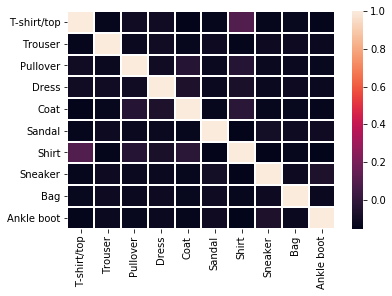

In [86]:
con_matrix = sklearn.metrics.confusion_matrix(final_predictions, all_labels)
con_matrix = pd.DataFrame(con_matrix)
con_matrix = con_matrix.corr()
sns.heatmap(con_matrix, xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                                                    'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                                                    'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], linecolor='white', linewidth=1)


In [87]:
print(sklearn.metrics.classification_report(final_predictions, all_labels))

             precision    recall  f1-score   support

          0       0.82      0.91      0.86       910
          1       0.97      1.00      0.99       974
          2       0.92      0.87      0.89      1059
          3       0.94      0.88      0.91      1071
          4       0.87      0.89      0.88       980
          5       0.98      0.98      0.98       999
          6       0.78      0.78      0.78      1005
          7       0.98      0.95      0.97      1035
          8       0.98      0.98      0.98       999
          9       0.95      0.99      0.97       968

avg / total       0.92      0.92      0.92     10000

